# Sparameter and Power Data 
This notebook demonstrates how to open many data sources, arrange the data and combine it into a single csv file. Note, because of the size of the data sources involved they are not included. For more information please contact [Aric Sanders](mailto:aric.sanders@nist.gov)


## Import and transformation of data files to a database
### There are several different sources of structured data each one with formatting differences
### Check Standard data sources
1. One Port Raw files that have been converted using Ron Ginley's BDAT -> Ascii converter
2. One Port files already stored in a legacy SAS database exported into csv by Jolene Spett
3. Two Port Raw files that have been converted using Ron Ginley's BDAT -> Ascii converter
4. Two Port files already stored in a legacy SAS database exported into csv by Jolene Spett
5. Two Port Non-Reciprocal files that have been converted using Ron Ginley's BDAT -> Ascii converter
6. Power Raw files files that have been converted using Ron Ginley's BDAT -> Ascii converter
7. Power files already stored in a legacy SAS database exported into csv by Jolene Spett

### DUT data sources, already analyzed using various versions of the Calrep HP Basic program
1. One Port .asc files stored in ascii.dut folder
2. Two Port .asc files stored in ascii.dut folder
3. Power .asc files with 4 error columns per s-parameter and power value stored in ascii.dut folder
4. Power .asc files with 3 error columns per power value stored in ascii.dut

### Conversion of these files requires: opening, parsing, and standardization of the data

In [1]:
# import of needed libraries
import os
import re
import datetime
import pandas
from types import *
# import of pyMez to change to import pyMez when __init__.py is changed
from pyMez.Code.DataHandlers.NISTModels import *
from pyMez.Code.Utils.Names import *
import numpy as np
import matplotlib.pyplot as plt


The module smithplot was not found,please put it on the python path


In [2]:
# Location of the various data sources
#input data sources
CONVERTED_RAW_FILE_DIRECTORY=r'C:\Share\Ck_Std_raw_ascii'
SAS_ONE_PORT=os.path.join(TESTS_DIRECTORY,'onechks.csv')
SAS_TWO_PORT=os.path.join(TESTS_DIRECTORY,'twochks.csv')
SAS_POWER=os.path.join(TESTS_DIRECTORY,'powchks.csv')
DUT_TOP_DIRECTORY=r'C:\Share\ascii.dut'
# output data 
ONE_PORT_CHKSTD_CSV=r"C:\Share\Converted_Check_Standard\One_Port_Check_Standard.csv"
TWO_PORT_CHKSTD_CSV=r"C:\Share\Converted_Check_Standard\Two_Port_Check_Standard.csv"
TWO_PORT_NR_CHKSTD_CSV=r"C:\Share\Converted_Check_Standard\Two_Port_NR_Check_Standard.csv"
POWER_CHKSTD_CSV=r"C:\Share\Converted_Check_Standard\Power_Check_Standard.csv"
COMBINED_ONE_PORT_CHKSTD_CSV=r"C:\Share\Converted_Check_Standard\Combined_One_Port_Check_Standard.csv"
COMBINED_TWO_PORT_CHKSTD_CSV=r"C:\Share\Converted_Check_Standard\Combined_Two_Port_Check_Standard.csv"
COMBINED_POWER_CHKSTD_CSV=r"C:\Share\Converted_Check_Standard\Combined_Power_Check_Standard.csv"
ONE_PORT_CALREP_CSV=r"C:\Share\Converted_DUT\One_Port_DUT.csv"
TWO_PORT_CALREP_CSV=r"C:\Share\Converted_DUT\Two_Port_DUT.csv"
POWER_3TERM_CALREP_CSV=r"C:\Share\Converted_DUT\Power_3Term_DUT.csv"
POWER_4TERM_CALREP_CSV=r"C:\Share\Converted_DUT\Power_4Term_DUT.csv"
SQL_DATABASE=r"C:\Share\Sql_DUT_Checkstandard\sqlite_sparameter_power.db"

### Creating import lists by type for the converted raw data sources
1. We read all the files in the top folder
2. The 5th line in the header determines the data type (python is zero indexed so it is element 4)
3. We create 4 lists of all files matching the various types (One-port, Two-Port, Two-PortNR, Power)

In [3]:
# We first get all files in the desired directory
file_names=os.listdir(CONVERTED_RAW_FILE_DIRECTORY)
# The loop runs quicker if we create lists and then add to them
# We create lists of the full path name for each of the data types
raw_files=[]
one_port_raw_files=[]
two_port_raw_files=[]
two_port_NR_raw_files=[]
power_raw_files=[]
# We iterate through the fiel names using the 5 th line to sort into our types
for index,file_name in enumerate(file_names[:]):
    in_file=open(os.path.join(CONVERTED_RAW_FILE_DIRECTORY,file_name),'r')
    lines=[]
    for line in in_file:
        lines.append(line)
    in_file.close()
    #print index,file_name
    if re.search('1-port',lines[4],re.IGNORECASE):
        one_port_raw_files.append(os.path.join(CONVERTED_RAW_FILE_DIRECTORY,file_name))
    elif re.search('2-port',lines[4],re.IGNORECASE) and not re.search('2-portNR',lines[4],re.IGNORECASE):
        two_port_raw_files.append(os.path.join(CONVERTED_RAW_FILE_DIRECTORY,file_name))
    elif re.search('2-portNR',lines[4],re.IGNORECASE):
        two_port_NR_raw_files.append(os.path.join(CONVERTED_RAW_FILE_DIRECTORY,file_name))
    elif re.search('Thermistor|Dry Cal',lines[4],re.IGNORECASE):
        power_raw_files.append(os.path.join(CONVERTED_RAW_FILE_DIRECTORY,file_name))
        
# This loop takes about 10 seconds

In [4]:
# Now we can check if the loop worked properly 
print("There are %s total files"%len(file_names))
print("There are %s one port raw files"%len(one_port_raw_files))
print("There are %s two port raw files"%len(two_port_raw_files))
print("There are %s two port NR raw files"%len(two_port_NR_raw_files))
print("There are %s power raw files"%len(power_raw_files))
total_binned_files=(len(one_port_raw_files)+len(two_port_raw_files)+len(two_port_NR_raw_files)+len(power_raw_files))
if len(file_names)==total_binned_files:
    print("All Files Have Been Acounted For")
else:
    print("{0} out of {1} files were binned".format(total_binned_files,len(file_names)) )

There are 6561 total files
There are 3636 one port raw files
There are 1574 two port raw files
There are 210 two port NR raw files
There are 1141 power raw files
All Files Have Been Acounted For


In [5]:
# Now each data source has to be parsed and converted to a common form
# One large issue is checking for data overlap in the data sources that can be solved by analysing the timestamp
# Also after trying several ways of doing the conversion, the best seems to be create a small csv and then add on 
def build_csv_from_raw_script(input_file_names_list,output_file_name,model_name):
    """Build csv from raw script takes a list of file names conforming to model and builds a single csv. 
    It is intentioned to accept raw files from the sparameter power project that have been converted from bdat
    using Ron Ginely's convertor (modified calrep program). The output is a single csv file with metadata added
    as extra columns (ie a denormalized table)"""
    try:
        # our current definition of metadata keys for all of the raw models
        metadata_keys=["System_Id","System_Letter","Connector_Type_Calibration","Connector_Type_Measurement",
              "Measurement_Type","Measurement_Date","Measurement_Time","Program_Used","Program_Revision","Operator",
              "Calibration_Name","Calibration_Date","Port_Used","Number_Connects","Number_Repeats","Nbs",
              "Number_Frequencies","Start_Frequency",
              "Device_Description","Device_Id"]
        # import the first file
        model=globals()[model_name]
        initial_file=model(input_file_names_list[0])
        # Add the metadata columns and replace any commas with - 
        for column_name in metadata_keys:
            initial_file.add_column(column_name=column_name,column_type='str',
                            column_data=[initial_file.metadata[column_name].replace(',','-') 
                                         for row in initial_file.data])
        # We also add a column at the end that is Measurement_Timestamp, that is 
        # Measurement_Time+Measurement_Date in isoformat
        timestamp=initial_file.metadata["Measurement_Date"]+" "+initial_file.metadata["Measurement_Time"]
        datetime_timestamp=datetime.datetime.strptime(timestamp,'%d %b %Y %H:%M:%S')
        measurement_timestamp=datetime_timestamp.isoformat(' ')
        initial_file.add_column(column_name="Measurement_Timestamp",column_type='str',
                            column_data=[measurement_timestamp
                                         for row in initial_file.data])
        # now we save the intial file with its column names but not its header
        initial_file.header=None
        initial_file.save(output_file_name)
        
        # Now we re-open this file in the append mode and read-in each new file and append it. This seems to work
        # for very large data sets, where as keeping a single object in memory fails
        out_file=open(output_file_name,'a')
        # now we do the same thing over and over and add it to the out file
        for file_name in input_file_names_list[1:]:
            
            model=globals()[model_name]
            parsed_file=model(file_name)
            for column_name in metadata_keys:
                parsed_file.add_column(column_name=column_name,column_type='str',
                            column_data=[parsed_file.metadata[column_name].replace(',','-') 
                                         for row in parsed_file.data])
            timestamp=parsed_file.metadata["Measurement_Date"]+" "+parsed_file.metadata["Measurement_Time"]
            datetime_timestamp=datetime.datetime.strptime(timestamp,'%d %b %Y %H:%M:%S')
            measurement_timestamp=datetime_timestamp.isoformat(' ')
            parsed_file.add_column(column_name="Measurement_Timestamp",column_type='str',
                            column_data=[measurement_timestamp
                                         for row in parsed_file.data])
            # add an endline before appending
            out_file.write('\n')
            # now we only want the data string
            data=parsed_file.get_data_string()
            out_file.write(data)
        # close the file after  loop
        out_file.close()
    # Catch any errors
    except:
            raise
        

In [7]:
# Now we can try it for a subset of one ports
build_csv_from_raw_script(one_port_raw_files[:10],ONE_PORT_CHKSTD_CSV,"OnePortRawModel")
# we re-import the csv using pandas to make sure it worked
one_port_raw_data_frame=pandas.read_csv(ONE_PORT_CHKSTD_CSV)
one_port_raw_data_frame[:5]

,Frequency,Direction,Connect,mag,arg,System_Id,System_Letter,Connector_Type_Calibration,Connector_Type_Measurement,Measurement_Type,...,Calibration_Date,Port_Used,Number_Connects,Number_Repeats,Nbs,Number_Frequencies,Start_Frequency,Device_Description,Device_Id,Measurement_Timestamp
0,0.0001,1,1,0.7560,-39.35,HP8510,K,NaN,N,1-port,...,NaN,1,3,1,1,73,7,00080 w/HP432A,80,2012-07-25 19:25:47
1,0.0001,1,2,0.7561,-39.35,HP8510,K,NaN,N,1-port,...,NaN,1,3,1,1,73,7,00080 w/HP432A,80,2012-07-25 19:25:47
2,0.0001,1,3,0.7561,-39.35,HP8510,K,NaN,N,1-port,...,NaN,1,3,1,1,73,7,00080 w/HP432A,80,2012-07-25 19:25:47
3,0.0002,1,1,0.5091,-57.61,HP8510,K,NaN,N,1-port,...,NaN,1,3,1,1,73,7,00080 w/HP432A,80,2012-07-25 19:25:47
4,0.0002,1,2,0.5091,-57.62,HP8510,K,NaN,N,1-port,...,NaN,1,3,1,1,73,7,00080 w/HP432A,80,2012-07-25 19:25:47


In [8]:
%timeit build_csv_from_raw_script(one_port_raw_files[:10],ONE_PORT_CHKSTD_CSV,"OnePortRawModel")

10 loops, best of 3: 152 ms per loop


In [36]:
# This loop takes ~ 16.3 ms to run for a file so 16.3ms * num_files
16.3*10**-3*len(one_port_raw_files)

59.26680000000001

In [9]:
# Let's do all of the files and time it, this loop will be the worst case senario
import_list=one_port_raw_files[:]
start_time=datetime.datetime.now()
build_csv_from_raw_script(import_list,ONE_PORT_CHKSTD_CSV,"OnePortRawModel")
stop_time=datetime.datetime.now()
diff=stop_time-start_time
print("{0} files were converted to a single csv in {1} seconds".format(len(import_list),diff.total_seconds()))

3636 files were converted to a single csv in 122.528 seconds


<IPython.core.display.Javascript object>


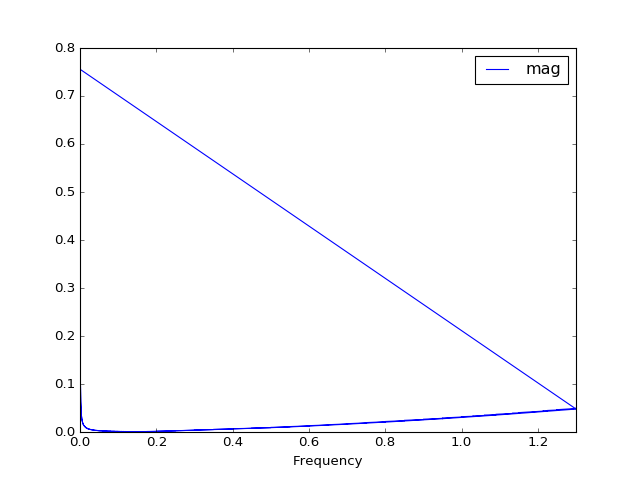

In [11]:
%matplotlib notebook
# Now let's check the integrity of the data by re-importing, selecting and plotting some of it
one_port_raw_data_frame=pandas.read_csv(ONE_PORT_CHKSTD_CSV)
test_subset=one_port_raw_data_frame[one_port_raw_data_frame["Device_Id"]==80]
if COMBINE_S11_S22:
    test_subset.plot(x="Frequency",y="mag")
else:
    test_subset.plot(x="Frequency",y="magS11")
plt.show()

In [44]:
# now 2 port

import_list=two_port_raw_files[:]
start_time=datetime.datetime.now()
build_csv_from_raw_script(import_list,TWO_PORT_CHKSTD_CSV,"TwoPortRawModel")
stop_time=datetime.datetime.now()
diff=stop_time-start_time
print("{0} files were converted to a single csv in {1} seconds".format(len(import_list),diff.total_seconds()))

1574 files were converted to a single csv in 31.946 seconds


In [45]:
# now 2 port NR

import_list=two_port_NR_raw_files[:]
start_time=datetime.datetime.now()
build_csv_from_raw_script(import_list,TWO_PORT_NR_CHKSTD_CSV,"TwoPortNRRawModel")
stop_time=datetime.datetime.now()
diff=stop_time-start_time
print("{0} files were converted to a single csv in {1} seconds".format(len(import_list),diff.total_seconds()))

210 files were converted to a single csv in 10.689 seconds


In [46]:
# now power

import_list=power_raw_files[:]
start_time=datetime.datetime.now()
build_csv_from_raw_script(import_list,POWER_CHKSTD_CSV,"PowerRawModel")
stop_time=datetime.datetime.now()
diff=stop_time-start_time
print("{0} files were converted to a single csv in {1} seconds".format(len(import_list),diff.total_seconds()))

1141 files were converted to a single csv in 7.684 seconds


### Now that the conversion of the raw data files is finished, we need to import data from the legacy SAS database, check to see if it is in the csv file, and if it is not add it. It should be noted that the data in the SAS database has a different number of columns, so that some of them need to be translated. In addition, there is no SAS equivelent to two port NR.

### Adition of data process
1. import tables of new raw and SAS types
2. rename any columns that are equivelent
3. create any columns that are converted forms (dates)
4. delete any extra columns
5. add empty columns for undefined values
6. exclude any that appear in new raw data set
7. export new joined file


In [12]:
# step 1: import data sets
raw_one_port=pandas.read_csv(ONE_PORT_CHKSTD_CSV)
sas_one_port=pandas.read_csv(SAS_ONE_PORT)

In [13]:
# step 2: rename any columns that are the same with different names
same={"spid":"System_Id","SP":"Port_Used","ctype":"Connector_Type_Measurement","checkid":"Device_Id",
     "MGAMA":"magS11","PGAMA":"argS11","CON":"Connect","FREQ":"Frequency"}
if COMBINE_S11_S22:
    same["MGAMA"]="mag"
    same["PGAMA"]="arg"
new=sas_one_port.rename(columns=same)

In [14]:
# step 3: create derived columns
def date_conversion(date_sas_format):
    datetime_format=datetime.datetime.strptime(date_sas_format,'%d%b%y:%H:%M:%S')
    return datetime_format.isoformat(" ")
def to_measurement_date(date_sas_format):
    datetime_format=datetime.datetime.strptime(date_sas_format,'%d%b%y:%H:%M:%S')
    return datetime_format.strftime("%d %b %y")
def to_measurement_time(date_sas_format):
    datetime_format=datetime.datetime.strptime(date_sas_format,'%d%b%y:%H:%M:%S')
    return datetime_format.strftime("%H:%M:%S")
def to_calibration_date(date_sas_format):
    if type(date_sas_format) is StringType:
        datetime_format=datetime.datetime.strptime(str(date_sas_format),'%d%b%y:%H:%M:%S')
        return datetime_format.strftime("%d %b %y")
    else:
        return date_sas_format
new["Measurement_Timestamp"]=new["MEASDATE"].map(date_conversion)
new["Measurement_Date"]=new["MEASDATE"].map(to_measurement_date)
new["Measurement_Time"]=new["MEASDATE"].map(to_measurement_time)
new["Calibration_Date"]=new["CALDATE"].map(to_calibration_date)
if COMBINE_S11_S22:
    pass
else:
    new["magS22"]=0.0
    new["argS22"]=0.0
new["Measurement_Type"]='1-port'

In [15]:
# step 4: delete any extra columns
del new["CALDATE"]
del new["MEASDATE"]
del new["CAL"]

In [16]:
# check our progress
new[:5]

,Connector_Type_Measurement,System_Id,Device_Id,Frequency,Connect,Port_Used,mag,arg,Measurement_Timestamp,Measurement_Date,Measurement_Time,Calibration_Date,Measurement_Type
0,7 mm,"System 2,6",C07101,2.0,1,1,0.19937,35.400,1993-08-10 08:31:01,10 Aug 93,08:31:01,02 Aug 93,1-port
1,7 mm,"System 2,6",C07101,2.0,2,1,0.19932,35.401,1993-08-10 08:31:01,10 Aug 93,08:31:01,02 Aug 93,1-port
2,7 mm,"System 2,6",C07101,2.0,3,1,0.19934,35.397,1993-08-10 08:31:01,10 Aug 93,08:31:01,02 Aug 93,1-port
3,7 mm,"System 2,6",C07101,3.0,1,1,0.20243,-37.995,1993-08-10 08:31:01,10 Aug 93,08:31:01,02 Aug 93,1-port
4,7 mm,"System 2,6",C07101,3.0,2,1,0.20252,-37.986,1993-08-10 08:31:01,10 Aug 93,08:31:01,02 Aug 93,1-port


In [17]:
# step 5: add empty columns
empty_columns=[ u'Direction',  u'System_Letter',
       u'Connector_Type_Calibration', u'Program_Used', u'Program_Revision', u'Operator', u'Calibration_Name',
       u'Number_Connects',
       u'Number_Repeats', u'Nbs', u'Number_Frequencies', u'Start_Frequency',
       u'Device_Description']
for empty_column in empty_columns:
    new[empty_column]=None

In [18]:
# Now check that the column names are the same and order them
raw_columns=raw_one_port.columns
print raw_columns
new=new[raw_columns]
new_columns=new.columns
print new_columns
raw_columns==new_columns

Index([u'Frequency', u'Direction', u'Connect', u'mag', u'arg', u'System_Id',
       u'System_Letter', u'Connector_Type_Calibration',
       u'Connector_Type_Measurement', u'Measurement_Type', u'Measurement_Date',
       u'Measurement_Time', u'Program_Used', u'Program_Revision', u'Operator',
       u'Calibration_Name', u'Calibration_Date', u'Port_Used',
       u'Number_Connects', u'Number_Repeats', u'Nbs', u'Number_Frequencies',
       u'Start_Frequency', u'Device_Description', u'Device_Id',
       u'Measurement_Timestamp'],
      dtype='object')
Index([                 u'Frequency',                  u'Direction',
                          u'Connect',                        u'mag',
                              u'arg',                  u'System_Id',
                    u'System_Letter', u'Connector_Type_Calibration',
       u'Connector_Type_Measurement',           u'Measurement_Type',
                 u'Measurement_Date',           u'Measurement_Time',
                     u'Program_Use

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True], dtype=bool)

In [19]:
# step 6: exclude any files that already exist
unique_timestamps=raw_one_port["Measurement_Timestamp"].unique()
new=new[-new["Measurement_Timestamp"].isin(unique_timestamps)]

In [20]:
# step7: add the files and save as csv, note at this point we can write to a db also
combined=pandas.concat([raw_one_port,new])
# combined["mag"]=combined["magS11"]+combined["magS22"]
# combined["arg"]=combined["argS11"]+combined["argS22"]
# del combined["magS11"]
# del combined["magS22"]
# del combined["argS11"]
# del combined["argS22"]
# column_order=[u'Frequency', u'Direction', u'Connect', u'mag', u'arg',  u'System_Id', u'System_Letter',
#        u'Connector_Type_Calibration', u'Connector_Type_Measurement',
#        u'Measurement_Type', u'Measurement_Date', u'Measurement_Time',
#        u'Program_Used', u'Program_Revision', u'Operator', u'Calibration_Name',
#        u'Calibration_Date', u'Port_Used', u'Number_Connects',
#        u'Number_Repeats', u'Nbs', u'Number_Frequencies', u'Start_Frequency',
#        u'Device_Description', u'Device_Id', u'Measurement_Timestamp']
combined.to_csv(COMBINED_ONE_PORT_CHKSTD_CSV,index=False)

In [21]:
# Finally we check that the files are all what we expect
number_measurements_raw=len(raw_one_port["Measurement_Timestamp"].unique())
number_measurements_sas=len(sas_one_port["MEASDATE"].unique())
number_new=len(new["Measurement_Timestamp"].unique())
number_combined=len(combined["Measurement_Timestamp"].unique())
print("There were {0} measurements in the raw one port files".format(number_measurements_raw))
print("There were {0} measurements in the sas one port files".format(number_measurements_sas))
print("{0} measurements did not overlap".format(number_new))
print("This resulted in {0} unique measurements".format(number_combined))
print("The statement that the number of raw + non-overlapping measurements is equal to the number of" 
      "combined measurements is {0}, resulting in {1} rows of"
      "data".format(number_new+number_measurements_raw==number_combined,len(combined)))

There were 3407 measurements in the raw one port files
There were 1959 measurements in the sas one port files
1679 measurements did not overlap
This resulted in 5086 unique measurements
The statement that the number of raw + non-overlapping measurements is equal to the number ofcombined measurements is True, resulting in 1700761 rows ofdata


In [22]:
# show a detailed row count, showing how many values are empty
combined.count()

Frequency                     1700761
Direction                     1579726
Connect                       1700761
mag                           1700761
arg                           1700761
System_Id                     1700761
System_Letter                 1579726
Connector_Type_Calibration      50468
Connector_Type_Measurement    1700761
Measurement_Type              1700761
Measurement_Date              1700761
Measurement_Time              1700761
Program_Used                  1579726
Program_Revision              1579726
Operator                      1579726
Calibration_Name               643520
Calibration_Date               171502
Port_Used                     1700761
Number_Connects               1579726
Number_Repeats                1579726
Nbs                           1579726
Number_Frequencies            1579726
Start_Frequency               1579726
Device_Description            1579726
Device_Id                     1700761
Measurement_Timestamp         1700761
dtype: int64

In [23]:
# Finaly check the data by importing it 
start_time=datetime.datetime.now()
combined_csv=pandas.read_csv(COMBINED_ONE_PORT_CHKSTD_CSV)
stop_time=datetime.datetime.now()
diff=stop_time-start_time
print("{0} files were imported as a single csv in {1} seconds".format(len(combined_csv),diff.total_seconds()))
combined_csv.count()

1700761 files were imported as a single csv in 5.585 seconds


C:\Anaconda2\lib\site-packages\IPython\core\interactiveshell.py:2902: DtypeWarning: Columns (6,7,8,12,14,15,16,23,24) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Frequency                     1700761
Direction                     1579726
Connect                       1700761
mag                           1700761
arg                           1700761
System_Id                     1700761
System_Letter                 1579726
Connector_Type_Calibration      50468
Connector_Type_Measurement    1700761
Measurement_Type              1700761
Measurement_Date              1700761
Measurement_Time              1700761
Program_Used                  1579726
Program_Revision              1579726
Operator                      1579726
Calibration_Name               643520
Calibration_Date               171502
Port_Used                     1700761
Number_Connects               1579726
Number_Repeats                1579726
Nbs                           1579726
Number_Frequencies            1579726
Start_Frequency               1579726
Device_Description            1579726
Device_Id                     1700761
Measurement_Timestamp         1700761
dtype: int64

In [24]:
number_standards=len(combined_csv["Device_Id"].unique())
print("The number of 1-port check standards is {0}".format(number_standards))

The number of 1-port check standards is 292


### Repeat for 2-ports

In [5]:
# todo: make this a stand alone script
# step 1: import data sets
raw_two_port=pandas.read_csv(TWO_PORT_CHKSTD_CSV)
sas_two_port=pandas.read_csv(SAS_TWO_PORT)
# step 2: rename any columns that are the same with different names
same={"spid":"System_Id","SP":"Port_Used","ctype":"Connector_Type_Measurement","checkid":"Device_Id",
     "MS11":"magS11","PS11":"argS11","PS12":"argS21","MS22":"magS22","PS22":"argS22",
      "CON":"Connect","FREQ":"Frequency"}
new=sas_two_port.rename(columns=same)
# step 3: create derived columns
def date_conversion(date_sas_format):
    datetime_format=datetime.datetime.strptime(date_sas_format,'%d%b%y:%H:%M:%S')
    return datetime_format.isoformat(" ")
def to_measurement_date(date_sas_format):
    datetime_format=datetime.datetime.strptime(date_sas_format,'%d%b%y:%H:%M:%S')
    return datetime_format.strftime("%d %b %y")
def to_measurement_time(date_sas_format):
    datetime_format=datetime.datetime.strptime(date_sas_format,'%d%b%y:%H:%M:%S')
    return datetime_format.strftime("%H:%M:%S")
def to_calibration_date(date_sas_format):
    if type(date_sas_format) is StringType:
        datetime_format=datetime.datetime.strptime(str(date_sas_format),'%d%b%y:%H:%M:%S')
        return datetime_format.strftime("%d %b %y")
    else:
        return date_sas_format
def to_linear(s12_sas_format):
    return 10.**(-1.*s12_sas_format/20.)
new["Measurement_Timestamp"]=new["MEASDATE"].map(date_conversion)
new["Measurement_Date"]=new["MEASDATE"].map(to_measurement_date)
new["Measurement_Time"]=new["MEASDATE"].map(to_measurement_time)
new["Calibration_Date"]=new["CALDATE"].map(to_calibration_date)
new["magS21"]=new["MS12"].map(to_linear)
new["Measurement_Type"]='2-port'
# step 4: delete any extra columns
del new["CALDATE"]
del new["MEASDATE"]
del new["CAL"]
del new["MS12"]
# step 5: add empty columns
empty_columns=[ u'Direction',u'System_Letter',
       u'Connector_Type_Calibration', u'Program_Used', u'Program_Revision', u'Operator', u'Calibration_Name',
       u'Number_Connects',
       u'Number_Repeats', u'Nbs', u'Number_Frequencies', u'Start_Frequency',
       u'Device_Description']
for empty_column in empty_columns:
    new[empty_column]=None
# Now check that the column names are the same and order them
raw_columns=raw_two_port.columns
print raw_columns
new=new[raw_columns]
new_columns=new.columns
print new_columns
raw_columns==new_columns
# step 6: exclude any files that already exist
unique_timestamps=raw_two_port["Measurement_Timestamp"].unique()
new=new[-new["Measurement_Timestamp"].isin(unique_timestamps)]
# step7: add the files and save as csv, note at this point we can write to a db also
combined=pandas.concat([raw_two_port,new])
combined.to_csv(COMBINED_TWO_PORT_CHKSTD_CSV,index=False)
# Finally we check that the files are all what we expect
number_measurements_raw=len(raw_two_port["Measurement_Timestamp"].unique())
number_measurements_sas=len(sas_two_port["MEASDATE"].unique())
number_new=len(new["Measurement_Timestamp"].unique())
number_combined=len(combined["Measurement_Timestamp"].unique())
print("There were {0} measurements in the raw two port files".format(number_measurements_raw))
print("There were {0} measurements in the sas two port files".format(number_measurements_sas))
print("{0} measurements did not overlap".format(number_new))
print("This resulted in {0} unique measurements".format(number_combined))
print("The statement that the number of raw + non-overlapping measurements is equal to the number of " 
      "combined measurements is {0}, resulting in {1} rows of"
      "data".format(number_new+number_measurements_raw==number_combined,len(combined)))
# Finaly check the data by importing it 
start_time=datetime.datetime.now()
combined_csv=pandas.read_csv(COMBINED_TWO_PORT_CHKSTD_CSV)
stop_time=datetime.datetime.now()
diff=stop_time-start_time
print("{0} files were imported as a single csv in {1} seconds".format(len(combined_csv),diff.total_seconds()))
number_standards=len(combined_csv["Device_Id"].unique())
print("The number of 2-port check standards is {0}".format(number_standards))

Index([u'Frequency', u'Direction', u'Connect', u'magS11', u'argS11', u'magS21',
       u'argS21', u'magS22', u'argS22', u'System_Id', u'System_Letter',
       u'Connector_Type_Calibration', u'Connector_Type_Measurement',
       u'Measurement_Type', u'Measurement_Date', u'Measurement_Time',
       u'Program_Used', u'Program_Revision', u'Operator', u'Calibration_Name',
       u'Calibration_Date', u'Port_Used', u'Number_Connects',
       u'Number_Repeats', u'Nbs', u'Number_Frequencies', u'Start_Frequency',
       u'Device_Description', u'Device_Id', u'Measurement_Timestamp'],
      dtype='object')
Index([                 u'Frequency',                  u'Direction',
                          u'Connect',                     u'magS11',
                           u'argS11',                     u'magS21',
                           u'argS21',                     u'magS22',
                           u'argS22',                  u'System_Id',
                    u'System_Letter', u'Connector_Typ

### Repeat for power

In [107]:
raw_power=pandas.read_csv(POWER_CHKSTD_CSV)
sas_power=pandas.read_csv(SAS_POWER)
print raw_power.columns
print sas_power.columns

Index([u'Frequency', u'Direction', u'Connect', u'magS11', u'argS11',
       u'Efficiency', u'Calibration_Factor', u'System_Id', u'System_Letter',
       u'Connector_Type_Calibration', u'Connector_Type_Measurement',
       u'Measurement_Type', u'Measurement_Date', u'Measurement_Time',
       u'Program_Used', u'Program_Revision', u'Operator', u'Calibration_Name',
       u'Calibration_Date', u'Port_Used', u'Number_Connects',
       u'Number_Repeats', u'Nbs', u'Number_Frequencies', u'Start_Frequency',
       u'Device_Description', u'Device_Id', u'Measurement_Timestamp'],
      dtype='object')
Index([u'ctype', u'spid', u'checkid', u'CALDATE', u'MEASDATE', u'FREQ', u'CON',
       u'SP', u'MGAMA', u'PGAMA', u'KP', u'EFF', u'CAL'],
      dtype='object')


In [115]:
unique_cal=raw_power["Calibration_Factor"].unique()
test=sas_power[-sas_power["KP"].isin(unique_cal)]
print test

         ctype        spid checkid           CALDATE          MEASDATE   FREQ  \
0         WR15  HIJ-WR22/1  B15P04  12MAR02:14:52:19  12MAR02:17:51:58  50.00   
1         WR15  HIJ-WR22/1  B15P04  12MAR02:14:52:19  12MAR02:17:51:58  50.00   
2         WR15  HIJ-WR22/1  B15P04  12MAR02:14:52:19  12MAR02:17:51:58  50.00   
3         WR15  HIJ-WR22/1  B15P04  12MAR02:14:52:19  12MAR02:17:51:58  50.00   
4         WR15  HIJ-WR22/1  B15P04  13MAR02:12:58:16  13MAR02:17:22:12  55.00   
5         WR15  HIJ-WR22/1  B15P04  13MAR02:12:58:16  13MAR02:17:22:12  55.00   
6         WR15  HIJ-WR22/1  B15P04  13MAR02:12:58:16  13MAR02:17:22:12  55.00   
7         WR15  HIJ-WR22/1  B15P04  13MAR02:12:58:16  13MAR02:17:22:12  55.00   
8         WR15  HIJ-WR22/1  B15P04  14MAR02:10:37:33  14MAR02:15:50:24  56.00   
9         WR15  HIJ-WR22/1  B15P04  14MAR02:10:37:33  14MAR02:15:50:24  56.00   
10        WR15  HIJ-WR22/1  B15P04  14MAR02:10:37:33  14MAR02:15:50:24  56.00   
11        WR15  HIJ-WR22/1  

In [111]:
raw_power["Efficiency"].unique()

array([ 0.94455,  0.94473,  0.94493, ...,  0.99964,  0.99957,  0.99956])

In [118]:
# todo: make this a stand alone script
# step 1: import data sets
raw_power=pandas.read_csv(POWER_CHKSTD_CSV)
sas_power=pandas.read_csv(SAS_POWER)
# step 2: rename any columns that are the same with different names
same={"spid":"System_Id","SP":"Port_Used","ctype":"Connector_Type_Measurement","checkid":"Device_Id",
     "MGAMA":"magS11","PGAMA":"argS11","EFF":"Efficiency","KP":"Calibration_Factor",
      "CON":"Connect","FREQ":"Frequency"}
new=sas_power.rename(columns=same)
# step 3: create derived columns
def date_conversion(date_sas_format):
    datetime_format=datetime.datetime.strptime(date_sas_format,'%d%b%y:%H:%M:%S')
    return datetime_format.isoformat(" ")
def to_measurement_date(date_sas_format):
    datetime_format=datetime.datetime.strptime(date_sas_format,'%d%b%y:%H:%M:%S')
    return datetime_format.strftime("%d %b %y")
def to_measurement_time(date_sas_format):
    datetime_format=datetime.datetime.strptime(date_sas_format,'%d%b%y:%H:%M:%S')
    return datetime_format.strftime("%H:%M:%S")
def to_calibration_date(date_sas_format):
    if type(date_sas_format) is StringType:
        datetime_format=datetime.datetime.strptime(str(date_sas_format),'%d%b%y:%H:%M:%S')
        return datetime_format.strftime("%d %b %y")
    else:
        return date_sas_format
new["Measurement_Timestamp"]=new["MEASDATE"].map(date_conversion)
new["Measurement_Date"]=new["MEASDATE"].map(to_measurement_date)
new["Measurement_Time"]=new["MEASDATE"].map(to_measurement_time)
new["Calibration_Date"]=new["CALDATE"].map(to_calibration_date)
new["Measurement_Type"]='power'
# step 4: delete any extra columns
del new["CALDATE"]
del new["MEASDATE"]
del new["CAL"]
# step 5: add empty columns
empty_columns=[ u'Direction',  u'magS22',
       u'argS22',  u'System_Letter',
       u'Connector_Type_Calibration', u'Program_Used', u'Program_Revision', u'Operator', u'Calibration_Name',
       u'Number_Connects',
       u'Number_Repeats', u'Nbs', u'Number_Frequencies', u'Start_Frequency',
       u'Device_Description']
for empty_column in empty_columns:
    new[empty_column]=None
# Now check that the column names are the same and order them
raw_columns=raw_power.columns
print raw_columns
new=new[raw_columns]
new_columns=new.columns
print new_columns
raw_columns==new_columns
# step 6: exclude any files that already exist
unique_timestamps=raw_power["Measurement_Timestamp"].unique()
new=new[-new["Measurement_Timestamp"].isin(unique_timestamps)]
# step7: add the files and save as csv, note at this point we can write to a db also
combined=pandas.concat([raw_power,new])
combined.to_csv(COMBINED_POWER_CHKSTD_CSV,index=False)
# Finally we check that the files are all what we expect
number_measurements_raw=len(raw_power["Measurement_Timestamp"].unique())
number_measurements_sas=len(sas_power["MEASDATE"].unique())
number_new=len(new["Measurement_Timestamp"].unique())
number_combined=len(combined["Measurement_Timestamp"].unique())
print("There were {0} measurements in the raw power files".format(number_measurements_raw))
print("There were {0} measurements in the sas power files".format(number_measurements_sas))
print("{0} measurements did not overlap".format(number_new))
print("This resulted in {0} unique measurements".format(number_combined))
print("The statement that the number of raw + non-overlapping measurements is equal to the number of " 
      "combined measurements is {0}, resulting in {1} rows of "
      "data".format(number_new+number_measurements_raw==number_combined,len(combined)))
# Finaly check the data by importing it 
start_time=datetime.datetime.now()
combined_csv=pandas.read_csv(COMBINED_POWER_CHKSTD_CSV)
stop_time=datetime.datetime.now()
diff=stop_time-start_time
print("{0} files were imported as a single csv in {1} seconds".format(len(combined_csv),diff.total_seconds()))
number_standards=len(combined_csv["Device_Id"].unique())
print("The number of power check standards is {0}".format(number_standards))

Index([u'Frequency', u'Direction', u'Connect', u'magS11', u'argS11',
       u'Efficiency', u'Calibration_Factor', u'System_Id', u'System_Letter',
       u'Connector_Type_Calibration', u'Connector_Type_Measurement',
       u'Measurement_Type', u'Measurement_Date', u'Measurement_Time',
       u'Program_Used', u'Program_Revision', u'Operator', u'Calibration_Name',
       u'Calibration_Date', u'Port_Used', u'Number_Connects',
       u'Number_Repeats', u'Nbs', u'Number_Frequencies', u'Start_Frequency',
       u'Device_Description', u'Device_Id', u'Measurement_Timestamp'],
      dtype='object')
Index([                 u'Frequency',                  u'Direction',
                          u'Connect',                     u'magS11',
                           u'argS11',                 u'Efficiency',
               u'Calibration_Factor',                  u'System_Id',
                    u'System_Letter', u'Connector_Type_Calibration',
       u'Connector_Type_Measurement',           u'Measureme

### Now we import and shape the DUT files (.asc) 

In [3]:
one_port_files=[]
two_port_files=[]
power_files=[]
for root,directory,file_names in os.walk(DUT_TOP_DIRECTORY):
    #print file_names
    for file_name in file_names:
        match=re.search('.asc',file_name,re.IGNORECASE)
        
        try:
            if re.search('.txt',file_name,re.IGNORECASE):raise
            if match:
                in_file=open(os.path.join(root,file_name),'r')
                contents=in_file.read()
                in_file.close()
                if re.search('table 1',contents,re.IGNORECASE) and re.search('table 2',contents,re.IGNORECASE) and re.search('table 3',contents,re.IGNORECASE):
                    two_port_files.append(os.path.join(root,file_name))
                elif re.search('table 1',contents,re.IGNORECASE) and re.search('table 2',contents,re.IGNORECASE):
                    power_files.append(os.path.join(root,file_name))
                elif re.search('table 1',contents,re.IGNORECASE):
                    one_port_files.append(os.path.join(root,file_name))
                else:
                    pass
        except:pass

In [4]:
# check the files
print("There are %s one port calrep files"%len(one_port_files))
print("There are %s two port calrep files"%len(two_port_files))
print("There are %s power calrep files"%len(power_files))

There are 364 one port calrep files
There are 514 two port calrep files
There are 901 power calrep files


In [7]:
# We parse the file and extract Analysis_Date and Device_Id
start_time=datetime.datetime.now()
initial_file=OnePortCalrepModel(one_port_files[0])
device_id=initial_file.header[0].rstrip().lstrip()
print("{0} is {1}".format('device_id',device_id))
analysis_date=initial_file.header[1].rstrip().lstrip()
print("{0} is {1}".format('analysis_date',analysis_date))
initial_file.options["data_delimiter"]=","
initial_file.add_column(column_name='Device_Id',column_type='str',
                        column_data=[device_id for row in initial_file.data[:]])
initial_file.add_column(column_name='Analysis_Date',column_type='str',
                        column_data=[analysis_date for row in initial_file.data[:]])
#print initial_file
initial_file.header=None
initial_file.save(ONE_PORT_CALREP_CSV)
del initial_file
out_file=open(ONE_PORT_CALREP_CSV,'a')
file_list=one_port_files[1:]
for index,file_name in enumerate(file_list):
    try:
        print("Processing File Number {0}, {1}".format(index,file_name))
        one_port_table=OnePortCalrepModel(file_name)
        device_id=one_port_table.header[0].rstrip().lstrip()
        analysis_date=one_port_table.header[1].rstrip().lstrip()
        one_port_table.options["data_delimiter"]=","
        one_port_table.add_column(column_name='Device_Id',
                                  column_type='str',
                                  column_data=[device_id for row in one_port_table.data[:]])
        one_port_table.add_column(column_name='Analysis_Date',
                                  column_type='str',
                                  column_data=[analysis_date for row in one_port_table.data[:]])
        #print one_port_table
        out_file.write('\n')
        data=one_port_table.get_data_string()
        out_file.write(data)
        print one_port_table.header
        if index==len(file_list)-1:
            print("Last File")
        else:
            print("Next file is {0}".format(one_port_files[index+1]))
    except DataDimensionError:
        print("{0} was passed due to a data dimensioning problem".format(file_name))
        pass
    except AttributeError:
        print("{0} was passed due to a loading issue".format(file_name))
    except TypeError:
        print("{0} was passed due to an unkown issue".format(file_name))
    except TypeConversionError:
        print("{0} was passed due to improper number of columns".format(file_name))
    except ValueError:
        print("{0} was passed due to improper number of columns".format(file_name))
    except:raise
out_file.close()
stop_time=datetime.datetime.now()
diff=stop_time-start_time
print("{0} files were converted to a single csv in {1} seconds".format(len(file_list),diff.total_seconds()))

device_id is 02806
analysis_date is 9 Feb 2016
Processing File Number 0, C:\Share\ascii.dut\052101.asc
['052101', '10 Mar 2016', '\r']
Next file is C:\Share\ascii.dut\052101.asc
Processing File Number 1, C:\Share\ascii.dut\060127.asc
['060127', '10 Mar 2016', '\r']
Next file is C:\Share\ascii.dut\060127.asc
Processing File Number 2, C:\Share\ascii.dut\08046A.asc
['08046A', '29 Jan 2016', '\r']
Next file is C:\Share\ascii.dut\08046A.asc
Processing File Number 3, C:\Share\ascii.dut\08047A.asc
['08047A', '29 Jan 2016', '\r']
Next file is C:\Share\ascii.dut\08047A.asc
Processing File Number 4, C:\Share\ascii.dut\M105P1.asc
['M105P1', '18 Apr 2016', '\r']
Next file is C:\Share\ascii.dut\M105P1.asc
Processing File Number 5, C:\Share\ascii.dut\M105P2.asc
['M105P2', '20 Apr 2016', '\r']
Next file is C:\Share\ascii.dut\M105P2.asc
Processing File Number 6, C:\Share\ascii.dut\M110P2.asc
['M110P2', '20 Apr 2016', '\r']
Next file is C:\Share\ascii.dut\M110P2.asc
Processing File Number 7, C:\Share\a

In [8]:
#check the data
one_port_calrep_data_frame=pandas.read_csv(ONE_PORT_CALREP_CSV)
one_port_calrep_data_frame[:20]


,Frequency,mag,uMb,uMa,uMd,uMg,arg,uAb,uAa,uAd,uAg,Device_Id,Analysis_Date
0,0.05,1.0002,0.0020,0.0005,0.0001,0.0041,-2.21,0.11,0.03,0.00,0.23,02806,9 Feb 2016
1,0.06,1.0002,0.0019,0.0005,0.0000,0.0039,-2.67,0.11,0.03,0.00,0.22,02806,9 Feb 2016
2,0.07,1.0001,0.0018,0.0005,0.0000,0.0038,-3.12,0.11,0.03,0.00,0.22,02806,9 Feb 2016
3,0.08,1.0000,0.0018,0.0005,0.0000,0.0037,-3.58,0.10,0.03,0.00,0.21,02806,9 Feb 2016
4,0.09,1.0000,0.0018,0.0005,0.0000,0.0037,-4.03,0.10,0.03,0.00,0.21,02806,9 Feb 2016
5,0.10,1.0001,0.0018,0.0005,0.0001,0.0037,-4.49,0.10,0.03,0.02,0.21,02806,9 Feb 2016
6,0.15,1.0001,0.0017,0.0005,0.0000,0.0036,-6.73,0.10,0.03,0.00,0.21,02806,9 Feb 2016
7,0.20,1.0000,0.0017,0.0005,0.0000,0.0036,-8.98,0.10,0.03,0.00,0.20,02806,9 Feb 2016
8,0.25,0.9999,0.0017,0.0005,0.0000,0.0035,-11.23,0.10,0.03,0.00,0.20,02806,9 Feb 2016
9,0.30,1.0000,0.0017,0.0005,0.0000,0.0035,-13.49,0.10,0.03,0.00,0.20,02806,9 Feb 2016


In [12]:

# We parse the file and extract Analysis_Date and Device_Id
PRINT_REPORT=False
start_time=datetime.datetime.now()
initial_file=TwoPortCalrepModel(two_port_files[0])
device_id=initial_file.joined_table.header[0].rstrip().lstrip()
if PRINT_REPORT:
    print("{0} is {1}".format('device_id',device_id))
try:
    analysis_date=initial_file.joined_table.header[1].rstrip().lstrip()
except:
    analysis_date=""
if PRINT_REPORT:
    print("{0} is {1}".format('analysis_date',analysis_date))
initial_file.joined_table.options["data_delimiter"]=","
initial_file.joined_table.add_column(column_name='Device_Id',column_type='str',
                        column_data=[device_id for row in initial_file.joined_table.data[:]])
initial_file.joined_table.add_column(column_name='Analysis_Date',column_type='str',
                        column_data=[analysis_date for row in initial_file.joined_table.data[:]])
#print initial_file
initial_file.joined_table.header=None
initial_file.joined_table.save(TWO_PORT_CALREP_CSV)
del initial_file
out_file=open(TWO_PORT_CALREP_CSV,'a')
file_list=two_port_files[1:]
for index,file_name in enumerate(file_list):
    try:
        if PRINT_REPORT:
            print("Processing File Number {0}, {1}".format(index,file_name))
        two_port_table=TwoPortCalrepModel(file_name)
        device_id=two_port_table.joined_table.header[0].rstrip().lstrip()
        if PRINT_REPORT:
            print("{0} is {1}".format('device_id',device_id))
        try:
            analysis_date=two_port_table.joined_table.header[1].rstrip().lstrip()
        except:
            analysis_date=""
        if PRINT_REPORT:
            print("{0} is {1}".format('analysis_date',analysis_date))
        two_port_table.joined_table.options["data_delimiter"]=","
        two_port_table.joined_table.add_column(column_name='Device_Id',column_type='str',
                                column_data=[device_id for row in two_port_table.joined_table.data[:]])
        two_port_table.joined_table.add_column(column_name='Analysis_Date',column_type='str',
                                column_data=[analysis_date for row in two_port_table.joined_table.data[:]])
        out_file.write("\n")
        data=two_port_table.joined_table.get_data_string()
        out_file.write(data)
        if PRINT_REPORT:
            print two_port_table.joined_table.header
            if index==len(file_list)-1:
                print("Last File")
            else:
                print("Next file is {0}".format(two_port_files[index+1]))
    except DataDimensionError:
        print("{0} was passed due to a data dimensioning problem".format(file_name))
        pass
    except AttributeError:
        print("{0} was passed due to a loading issue".format(file_name))
    except TypeError:
        print("{0} was passed due to an unkown issue".format(file_name))
    except TypeConversionError:
        print("{0} was passed due to improper number of columns".format(file_name))
    except ValueError:
        print("{0} was passed due to improper number of columns".format(file_name))
    except:raise
out_file.close()
stop_time=datetime.datetime.now()
diff=stop_time-start_time
print("{0} files were converted to a single csv in {1} seconds".format(len(file_list),diff.total_seconds()))

C:\Share\ascii.dut\ascii.old\2003\922596.asc was passed due to a data dimensioning problem
C:\Share\ascii.dut\ascii.old\2003\922597.asc was passed due to a data dimensioning problem
C:\Share\ascii.dut\ascii.old\2003\922598.asc was passed due to a data dimensioning problem
C:\Share\ascii.dut\ascii.old\2003\922599.asc was passed due to a data dimensioning problem
C:\Share\ascii.dut\ascii.old\2003\922600.asc was passed due to a data dimensioning problem
C:\Share\ascii.dut\ascii.old\2003\922601.asc was passed due to a data dimensioning problem
C:\Share\ascii.dut\ascii.old\2004\700312.asc was passed due to a data dimensioning problem
C:\Share\ascii.dut\ascii.old\2004\700313.asc was passed due to a data dimensioning problem
C:\Share\ascii.dut\ascii.old\2004\700314.asc was passed due to a data dimensioning problem
C:\Share\ascii.dut\ascii.old\2004\700315.asc was passed due to a data dimensioning problem
C:\Share\ascii.dut\ascii.old\2004\700316.asc was passed due to a data dimensioning problem

In [14]:
#check the data
two_port_calrep_data_frame=pandas.read_csv(TWO_PORT_CALREP_CSV)
two_port_calrep_data_frame[:10]

,Frequency,magS11,uMbS11,uMaS11,uMdS11,uMgS11,argS11,uAbS11,uAaS11,uAdS11,...,uMaS22,uMdS22,uMgS22,argS22,uAbS22,uAaS22,uAdS22,uAgS22,Device_Id,Analysis_Date
0,0.10,0.0023,0.0035,0.0005,0.0001,0.0072,29.36,64.96,0.03,1.38,...,0.0005,0.0000,0.0072,21.67,72.00,0.03,2.02,144.01,000146,29 Jan 2016
1,0.15,0.0024,0.0035,0.0005,0.0000,0.0070,23.03,61.07,0.03,0.62,...,0.0005,0.0001,0.0070,17.13,60.29,0.03,1.56,120.60,000146,29 Jan 2016
2,0.20,0.0029,0.0034,0.0005,0.0001,0.0069,16.46,53.31,0.03,0.90,...,0.0005,0.0001,0.0069,8.78,57.30,0.03,0.53,114.60,000146,29 Jan 2016
3,0.25,0.0029,0.0034,0.0005,0.0001,0.0069,6.96,52.45,0.03,1.24,...,0.0005,0.0001,0.0069,3.49,51.65,0.03,0.75,103.29,000146,29 Jan 2016
4,0.30,0.0033,0.0034,0.0005,0.0001,0.0069,0.93,48.14,0.03,1.22,...,0.0005,0.0001,0.0069,-3.51,50.43,0.03,0.85,100.86,000146,29 Jan 2016
5,0.35,0.0033,0.0034,0.0005,0.0001,0.0069,-5.09,48.05,0.03,1.39,...,0.0005,0.0001,0.0069,-11.51,47.75,0.03,0.78,95.49,000146,29 Jan 2016
6,0.40,0.0034,0.0034,0.0005,0.0001,0.0069,-10.24,47.13,0.03,1.48,...,0.0005,0.0001,0.0069,-18.81,46.78,0.03,0.54,93.55,000146,29 Jan 2016
7,0.45,0.0034,0.0034,0.0005,0.0000,0.0068,-17.22,47.31,0.03,1.74,...,0.0005,0.0001,0.0068,-26.59,45.48,0.03,0.83,90.96,000146,29 Jan 2016
8,0.50,0.0035,0.0034,0.0005,0.0000,0.0068,-25.99,45.65,0.03,1.75,...,0.0005,0.0001,0.0068,-31.45,45.88,0.03,0.65,91.76,000146,29 Jan 2016
9,0.55,0.0036,0.0034,0.0005,0.0000,0.0068,-30.70,45.58,0.03,1.90,...,0.0005,0.0001,0.0068,-40.05,45.54,0.03,0.71,91.09,000146,29 Jan 2016


In [5]:
# First we separate the power list between the two types
power_3term=[]
power_4term=[]
for file_name in power_files:
    try:
        new_table=PowerCalrepModel(file_name)
        number_columns=len(new_table.joined_table.data[0])
        if number_columns == 19:
            power_3term.append(file_name)
        elif number_columns ==21:
            power_4term.append(file_name)
        else:
            print("{0} does not conform".format(file_name))
    except:
        print("{0} caused an error".format(file_name))
        pass

C:\Share\ascii.dut\ascii.old\700095.ASC dircomp caused an error
begin_line is 36
C:\Share\ascii.dut\ascii.old\2001\811671low.ASC caused an error
C:\Share\ascii.dut\ascii.old\2001\812069low.asc caused an error
C:\Share\ascii.dut\ascii.old\2002\814116.ASC caused an error
C:\Share\ascii.dut\ascii.old\2003\700194.ASC caused an error
C:\Share\ascii.dut\ascii.old\2003\810004.asc caused an error
C:\Share\ascii.dut\ascii.old\2003\813504.ASC caused an error
C:\Share\ascii.dut\ascii.old\2003\814114.ASC caused an error
C:\Share\ascii.dut\ascii.old\2003\814115.ASC caused an error
C:\Share\ascii.dut\ascii.old\2006\700091.ASC.1-5MHzdircompbiased caused an error
C:\Share\ascii.dut\ascii.old\2006\700091.ASCdircomp .0001-.100 GHzbiased caused an error
C:\Share\ascii.dut\ascii.old\2006\700185.ascBIASED caused an error
C:\Share\ascii.dut\ascii.old\2006\700185.ascUNbiased caused an error
C:\Share\ascii.dut\ascii.old\2006\700237low.asc biased Aug. 24,2006 caused an error
C:\Share\ascii.dut\ascii.old\2006\7

In [6]:
print("There are {0} three term files".format(len(power_3term)))
print("There are {0} four term files".format(len(power_4term)))

There are 694 three term files
There are 169 four term files


In [21]:
def power_calrep_to_csv_script(power_file_list,output_file,print_report=False):
    """ Script converts all of the files in power_file_list to a single csv file (output_file).
    Option to print a detailed report print_report=True."""
    PRINT_REPORT=print_report
    # start timer for analysis
    start_time=datetime.datetime.now()
    # seed file for format and column naems
    initial_file=PowerCalrepModel(power_file_list[0])
    # device id assumed to be the first line of header
    device_id=initial_file.joined_table.header[0].rstrip().lstrip()
    if PRINT_REPORT:
        print("{0} is {1}".format('device_id',device_id))
    # try and find the date in the header, since some of the dates are in different lines
    # flatten the header and remove the device id. If it fails just make analysis date blank.
    try:
        header=string_list_collapse(initial_file.joined_table.header[:],string_delimiter="")
        header=header.rstrip().lstrip().replace(device_id,"")
        analysis_date=header
    except:
        analysis_date=""
    if PRINT_REPORT:
        print("{0} is {1}".format('analysis_date',analysis_date))
    # insure that the data delimiter is a comma.
    initial_file.joined_table.options["data_delimiter"]=","
    # Add columns with device id and analysis date in them
    initial_file.joined_table.add_column(column_name='Device_Id',column_type='str',
                            column_data=[device_id for row in initial_file.joined_table.data[:]])
    initial_file.joined_table.add_column(column_name='Analysis_Date',column_type='str',
                            column_data=[analysis_date for row in initial_file.joined_table.data[:]])

                                         
    #print initial_file
    # remove the header for output purposes
    initial_file.joined_table.header=None
    # save the seed file with column names in csv format
    initial_file.joined_table.save(output_file)
    # clear the object from memory
    del initial_file    
    # now the initial write is completed open the file in append mode and append each file 
    out_file=open(output_file,'a')
    for index,file_name in enumerate(power_file_list):
        try:
            if PRINT_REPORT:
                print("Processing File Number {0}, {1}".format(index,file_name))
            table=PowerCalrepModel(file_name)
            # device id assumed to be the first line of header
            device_id=table.joined_table.header[0].rstrip().lstrip()
            if PRINT_REPORT:
                print("{0} is {1}".format('device_id',device_id))
            # try and find the date in the header, since some of the dates are in different lines
            # flatten the header and remove the device id. If it fails just make analysis date blank.
            try:
                header=string_list_collapse(table.joined_table.header[:],string_delimiter="")
                header=header.rstrip().lstrip().replace(device_id,"")
                analysis_date=header
            except:
                analysis_date=""
            if PRINT_REPORT:
                print("{0} is {1}".format('analysis_date',analysis_date))
            # insure that the data delimiter is a comma.
                print table.joined_table.header 
                print table.joined_table.column_names
                print("Data is {0} rows x {1} columns".format(len(table.joined_table.data),
                                                              len(table.joined_table.data[0])))
                if index==len(power_file_list)-1:
                    print("Last File")
                else:
                    print("Next file is {0}".format(power_files[index+1]))
            table.joined_table.options["data_delimiter"]=","
            # Add columns with device id and analysis date in them
            table.joined_table.add_column(column_name='Device_Id',column_type='str',
                                    column_data=[device_id for row in table.joined_table.data[:]])
            table.joined_table.add_column(column_name='Analysis_Date',column_type='str',
                                    column_data=[analysis_date for row in table.joined_table.data[:]])
            # write to out_file
            out_file.write("\n")
            data=table.joined_table.get_data_string()
            out_file.write(data)
        except DataDimensionError:
            print("{0} was passed due to a data dimensioning problem".format(file_name))
            pass
        except AttributeError:
            print("{0} was passed due to a loading issue".format(file_name))
        except ValueError:
            print("{0} was passed due to a column size issue".format(file_name))
        except:raise
    # Close out the script
    out_file.close()
    stop_time=datetime.datetime.now()
    diff=stop_time-start_time
    print("{0} files were converted to a single csv in {1} seconds".format(len(power_file_list),diff.total_seconds()))
                                         

In [22]:
# run the script for the two power types
power_calrep_to_csv_script(power_3term,POWER_3TERM_CALREP_CSV,print_report=False)

694 files were converted to a single csv in 10.393 seconds


In [23]:
power_calrep_to_csv_script(power_4term,POWER_4TERM_CALREP_CSV)

169 files were converted to a single csv in 1.16 seconds
